<a href="https://colab.research.google.com/github/cicattzo/nlp_project/blob/main/6864_project_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up dependencies and data

In [1]:
from google.colab import drive 
drive.mount("/content/drive")

#MODEL_FOLDER = "/content/drive/My Drive/mit-6864/project"
#!mkdir -p "/content/drive/My Drive/mit-6864/project"

Mounted at /content/drive


In [24]:
%%bash
git clone https://github.com/mit-6864/hw3.git
mkdir -p /content/hw3/data

fatal: destination path 'hw3' already exists and is not an empty directory.


In [3]:
!pip -q install transformers
#pip install datasets==1.0.2
!pip install sacrebleu
!pip install rouge_score

     |████████████████████████████████| 2.3MB 7.6MB/s 
     |████████████████████████████████| 3.3MB 49.3MB/s 
     |████████████████████████████████| 901kB 40.4MB/s 
     |████████████████████████████████| 61kB 5.0MB/s 


In [25]:
# Download data
DATA_DIR = "/content/hw3/data"
!wget -nv -O "$DATA_DIR/vocab.en" https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.en

2021-05-15 19:14:39 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.en [139741/139741] -> "/content/hw3/data/vocab.en" [1]


In [4]:
%%capture
import sacrebleu
from rouge_score import rouge_scorer
import pandas as pd
#train_ds = datasets.load_dataset("cnn_dailymail", "3.0.0", split="train")
#train = pd.DataFrame(train_ds)
#valid_ds = datasets.load_dataset("cnn_dailymail", "3.0.0", split="validation")

In [5]:
##Import Train and Test sets 
#
train = pd.read_csv("/content/drive/My Drive/6864_project/train_combined.csv")
print("Training Data Shape ", train.shape)
print("Training Data Columns ", train.columns)

Training Data Shape  (14824, 3)
Training Data Columns  Index(['article', 'highlights', 'id'], dtype='object')


In [6]:
test = pd.read_csv("/content/drive/My Drive/6864_project/bc3_test.csv")

print("Test Data Shape ", test.shape)
print("Test Data Columns ", test.columns)

Test Data Shape  (201, 5)
Test Data Columns  Index(['listno', 'subject', 'body', 'email_num', 'summary'], dtype='object')


In [7]:
#Naming convention to be followed - articles, highlights
test = test[["body", "summary"]]
test.columns = ["article", "highlights"]

In [8]:
#Get sentence lengths for training data set summaries and articles 
train["len"] = train["article"].apply(lambda x : len(x.split()))
train["sumlen"] = train["highlights"].apply(lambda x : len(x.split()))
print("Max sentence length for training dataset articles is ", max(train["len"]))
print("Max sentence length for training dataset summaries is ", max(train["sumlen"]))

Max sentence length for training dataset articles is  1876
Max sentence length for training dataset summaries is  121


In [9]:
#Get sentence lengths for training data set summaries and articles 
test["len"] = test["article"].apply(lambda x : len(x.split()))
test["sumlen"] = test["highlights"].apply(lambda x : len(x.split()))
print("Max sentence length for test dataset articles is ", max(test["len"]))
print("Max sentence length for test dataset summaries is ", max(test["sumlen"]))

Max sentence length for test dataset articles is  451
Max sentence length for test dataset summaries is  73


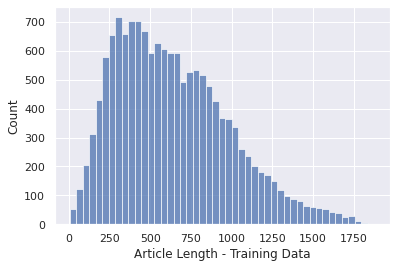

In [ ]:
#Plot ditributions for article and summary lengths in the training dataset
import seaborn as sns
sns.set()
%matplotlib inline
fig= sns.histplot(train["len"])
fig.set(xlabel='Article Length - Training Data')
plt.show()

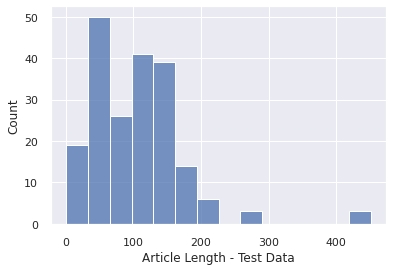

In [ ]:
sns.set()
%matplotlib inline
fig= sns.histplot(test["len"])
fig.set(xlabel='Article Length - Test Data')
plt.show()


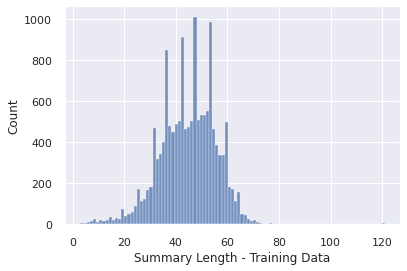

In [ ]:
#Plot ditributions for article and summary lengths in the training dataset
#import seaborn as sns
sns.set()
%matplotlib inline
fig= sns.histplot(train["sumlen"])
fig.set(xlabel='Summary Length - Training Data')
plt.show()

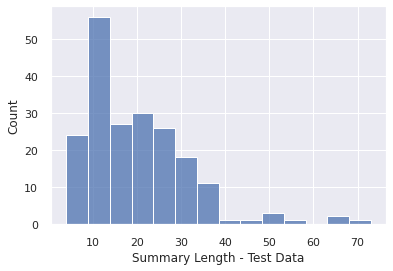

In [ ]:
sns.set()
%matplotlib inline
fig= sns.histplot(test["sumlen"])
fig.set(xlabel='Summary Length - Test Data')
plt.show()

In [11]:
#Select max sentence length 
train = train.query('len < 400 and sumlen < 400 and len >0 and sumlen >0')
test = test.query('len < 400 and sumlen < 400 and len >0 and sumlen >0')
print(train.shape)
print(test.shape)

(4358, 5)
(198, 4)


In [ ]:
#Uncomment to save dataframes 
#from google.colab import files
#train.to_csv('short_cnn.csv') 
#files.download('short_cnn.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
import sys
sys.path.append("/content/hw3")
import pandas as pd
import lab_utils
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import torch 
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"   # use gpu whenever you can!

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
#torch.cuda.empty_cache()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
#Preprocessing 
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [16]:
stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower() 
    text = text.split() 
    for i in range(len(text)):
        word = text[i]
        if word in contraction_mapping:
            text[i] = contraction_mapping[word]
    text = " ".join(text)
    text = text.split()
    newtext = []
    for word in text:
        if word not in stop_words:
            newtext.append(word)
    text = " ".join(newtext)
    text = text.replace("'s",'') 
    text = re.sub(r'\(.*\)','',text) # remove (words)
    text = re.sub(r'[^a-zA-Z. ]','',text) # remove punctuations but not full stop
    text = re.sub(r'\&','',text)  #Found very often in CNN dataset 
    text = re.sub(r'(cnn)|(new :)|(news :)','',text)
    text = re.sub(r' +',' ',text)
    return text
print(preprocess("123 kjenkdnwkjef jksdbkj wjdkjsd,cdnj...."))
print("123 kjenkdnwkjef jksdbkj wjdkjsd,cdnj....")

 kjenkdnwkjef jksdbkj wjdkjsdcdnj....
123 kjenkdnwkjef jksdbkj wjdkjsd,cdnj....


In [17]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [18]:
def convert_token_list(df, column):
  ## regex replace multiple occurences of - , > , < and covert .com to website 
  ts = df[column].values.tolist()
  tst =[]
  for i in range(df.shape[0]):
    tokens = word_tokenize(ts[i])
    tokens_stem=[]
    for word in tokens:
      wordt = ps.stem(word)
      tokens_stem.append(wordt)
    tst.append(tokens_stem)
  return tst 

In [19]:
train.loc[:,'highlights'] = train['highlights'].apply(lambda x:preprocess(x))
train.loc[:,'article'] = train['article'].apply(lambda x:preprocess(x))

In [20]:
test.loc[:,'highlights'] = test['highlights'].apply(lambda x:preprocess(x))
test.loc[:,'article'] = test['article'].apply(lambda x:preprocess(x))

In [21]:
train_src_sentences_list = convert_token_list(train, "article")
train_trg_sentences_list = convert_token_list(train, "highlights")
assert len(train_src_sentences_list) == len(train_trg_sentences_list)

test_src_sentences_list = convert_token_list(test, "article")
test_trg_sentences_list = convert_token_list(test, "highlights")
assert len(test_src_sentences_list) == len(test_trg_sentences_list)

MAX_SENT_LENGTH = 400
MAX_SENT_LENGTH_PLUS_SOS_EOS = MAX_SENT_LENGTH +2 

In [27]:
from lab_utils import read_vocab_file, read_sentence_file, filter_data
src_vocab = read_vocab_file("vocab.en")
print("Default vocab size ", len(src_vocab))
def_vocab = src_vocab[0:5]

Default vocab size  17192


In [28]:
src_vocab_set = def_vocab + list(set([i for j in train_src_sentences_list for i in j] + [i for j in train_trg_sentences_list for i in j]))
trg_vocab_set = src_vocab_set
print("Custom vocab size ", len(src_vocab_set))
#The size of this custom vocab is much higher than the default one. We will choose this one to avoid unk tokens 

Custom vocab size  30972


In [29]:

train_src_sentences_list, train_trg_sentences_list = filter_data(
    train_src_sentences_list, train_trg_sentences_list, MAX_SENT_LENGTH)
test_src_sentences_list, test_trg_sentences_list = filter_data(
    test_src_sentences_list, test_trg_sentences_list, MAX_SENT_LENGTH)

# We take 10% of training data as validation set.
num_val = int(len(train_src_sentences_list) * 0.1)
val_src_sentences_list = train_src_sentences_list[:num_val]
val_trg_sentences_list = train_trg_sentences_list[:num_val]
train_src_sentences_list = train_src_sentences_list[num_val:]
train_trg_sentences_list = train_trg_sentences_list[num_val:]



In [30]:
import torch
from torch.utils import data

# These IDs are reserved.
PAD_INDEX = 0
UNK_INDEX = 1
SOS_INDEX = 2
EOS_INDEX = 3


class MTDataset(data.Dataset):
  def __init__(self, src_sentences, src_vocabs, trg_sentences, trg_vocabs,
               sampling=1.):
    self.src_sentences = src_sentences[:int(len(src_sentences) * sampling)]
    self.trg_sentences = trg_sentences[:int(len(src_sentences) * sampling)]

    self.max_src_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS
    self.max_trg_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS

    self.src_vocabs = src_vocabs
    self.trg_vocabs = trg_vocabs

    self.src_v2id = {v : i for i, v in enumerate(src_vocabs)}
    self.src_id2v = {val : key for key, val in self.src_v2id.items()}
    self.trg_v2id = {v : i for i, v in enumerate(trg_vocabs)}
    self.trg_id2v = {val : key for key, val in self.trg_v2id.items()}

  def __len__(self):
    return len(self.src_sentences)

  def __getitem__(self, index):
    src_sent = self.src_sentences[index]
    src_len = len(src_sent) + 2   # add <s> and </s> to each sentence
    src_id = []
    for w in src_sent:
      if w not in self.src_vocabs:
        #print(w)
        w = '<unk>'
      src_id.append(self.src_v2id[w])
    src_id = ([SOS_INDEX] + src_id + [EOS_INDEX] + [PAD_INDEX] *
              (self.max_src_seq_length - src_len))

    trg_sent = self.trg_sentences[index]
    trg_len = len(trg_sent) + 2
    trg_id = []
    for w in trg_sent:
      if w not in self.trg_vocabs:
        w = '<unk>'
      trg_id.append(self.trg_v2id[w])
    trg_id = ([SOS_INDEX] + trg_id + [EOS_INDEX] + [PAD_INDEX] *
              (self.max_trg_seq_length - trg_len))

    return torch.tensor(src_id), src_len, torch.tensor(trg_id), trg_len

Encoder

In [31]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, dropout=0.):    
    super(Encoder, self).__init__()

    self.rnn = nn.GRU(input_size, hidden_size, num_layers=3, batch_first=True,
                      dropout=dropout, bidirectional=True)

  def forward(self, inputs, lengths):
    outputs = None
    finals = None
    #embeddings = self.dropout(self.embedding(x))
    
    packed = pack_padded_sequence(inputs, lengths.cpu(), batch_first=True,
                                  enforce_sorted=False)
    outputs, finals = self.rnn(packed)
    outputs, _ = pad_packed_sequence(outputs, batch_first=True,
                                     total_length=MAX_SENT_LENGTH_PLUS_SOS_EOS)

    return outputs, finals

## Decoder


In [32]:
class Decoder(nn.Module):
  """An RNN decoder without attention."""

  def __init__(self, input_size, hidden_size, dropout=0.):
    super(Decoder, self).__init__()

    
    self.rnn = nn.GRU(input_size, hidden_size, batch_first=True,
                      dropout=dropout)
    self.bridge = nn.Linear(hidden_size, hidden_size, bias=True)

    self.dropout_layer = nn.Dropout(p=dropout)
    self.pre_output_layer = nn.Linear(hidden_size + input_size, hidden_size,
                                      bias=False)
    

  def forward_step(self, prev_embed, hidden):

    pre_output = None

    pre_output, hidden = self.rnn(prev_embed, hidden) # minimun necessary

    pre_output = torch.cat([prev_embed, pre_output], dim=2)

    pre_output = self.dropout_layer(pre_output)
    pre_output = self.pre_output_layer(pre_output)

    return hidden, pre_output

  def forward(self, inputs, encoder_finals, hidden=None, max_len=None):

    if max_len is None:
      max_len = inputs.size(1)

    if hidden is None:
      hidden = self.init_hidden(encoder_finals)

    outputs = None

    pre_output_vectors = []

    for i in range(max_len):
      prev_embed = inputs[:, i].unsqueeze(1)
      hidden, pre_output = self.forward_step(prev_embed, hidden)
      pre_output_vectors.append(pre_output)

    outputs = torch.cat(pre_output_vectors, dim=1)

    return hidden, outputs

  def init_hidden(self, encoder_finals):
    """Use encoder final hidden state to initialize decoder's first hidden
    state."""
    decoder_init_hiddens = torch.tanh(self.bridge(encoder_finals))
    
    return decoder_init_hiddens

In [33]:
class EncoderDecoder(nn.Module):
  """A standard Encoder-Decoder architecture without attention.
  """
  def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
    super(EncoderDecoder, self).__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.generator = generator

  def forward(self, src_ids, trg_ids, src_lengths):
    encoder_hiddens, encoder_finals = self.encode(src_ids, src_lengths)
    del encoder_hiddens   # unused
    return self.decode(encoder_finals, trg_ids[:, :-1])

  def encode(self, src_ids, src_lengths):
    return self.encoder(self.src_embed(src_ids), src_lengths)
    
  def decode(self, encoder_finals, trg_ids, decoder_hidden=None):
    return self.decoder(self.trg_embed(trg_ids), encoder_finals, decoder_hidden)

In [34]:
class Generator(nn.Module):
  """Define standard linear + softmax generation step."""
  def __init__(self, hidden_size, vocab_size):
    super(Generator, self).__init__()
    self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

## Training

In [35]:
from torch.utils import data

batch_size = 32

train_set = MTDataset(train_src_sentences_list, src_vocab_set,
                      train_trg_sentences_list, trg_vocab_set, sampling=1.)
train_data_loader = data.DataLoader(train_set, batch_size=batch_size,
                                    num_workers=3, shuffle=True)
val_set = MTDataset(val_src_sentences_list, src_vocab_set,
                    val_trg_sentences_list, trg_vocab_set, sampling=1.)
val_data_loader = data.DataLoader(val_set, batch_size=batch_size, num_workers=3,
                                  shuffle=False)

In [36]:
import math


class SimpleLossCompute:
  """A simple loss compute and train function."""

  def __init__(self, generator, criterion, opt=None):
    self.generator = generator
    self.criterion = criterion
    self.opt = opt

  def __call__(self, x, y, norm):
    x = self.generator(x)
    loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                          y.contiguous().view(-1))
    loss = loss / norm

    if self.opt is not None:  # training mode
      loss.backward()          
      self.opt.step()
      self.opt.zero_grad()

    return loss.data.item()*norm
loss_fct =[]
def run_epoch(data_loader, model, loss_compute, print_every):
  """Standard Training and Logging Function"""

  total_tokens = 0
  total_loss = 0

  for i, (src_ids_BxT, src_lengths_B, trg_ids_BxL, trg_lengths_B) in enumerate(data_loader):

    src_ids_BxT = src_ids_BxT.to(device)
    src_lengths_B = src_lengths_B.to(device)
    trg_ids_BxL = trg_ids_BxL.to(device)

    del trg_lengths_B   # unused

    _, output = model(src_ids_BxT, trg_ids_BxL, src_lengths_B)

    loss = loss_compute(x=output, y=trg_ids_BxL[:, 1:],
                        norm=src_ids_BxT.size(0))
    total_loss += loss
    total_tokens += (trg_ids_BxL[:, 1:] != PAD_INDEX).data.sum().item()

    if model.training and i % print_every == 0:
      print("Epoch Step: %d Loss: %f" % (i, loss / src_ids_BxT.size(0)))
      loss_fct.append(loss / src_ids_BxT.size(0))

  return  loss/src_ids_BxT.size(0), math.exp(total_loss / float(total_tokens))


def train(model, num_epochs, learning_rate, print_every):
  criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
  optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Keep track of dev ppl for each epoch.
  dev_ppls = []
  losses =[]

  for epoch in range(num_epochs):
    print("Epoch", epoch)

    model.train()
    loss, train_ppl = run_epoch(data_loader=train_data_loader, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, optim),
                          print_every=print_every)
        
    model.eval()
    with torch.no_grad():      
      loss, dev_ppl = run_epoch(data_loader=val_data_loader, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, None),
                          print_every=print_every)
      print("Validation perplexity: %f" % dev_ppl)
      dev_ppls.append(dev_ppl)
      losses.append(loss)
        
  return  dev_ppls

### EncoderDecoder Training

In [ ]:
# Hyperparameters for contructing the encoder-decoder model.
embed_size = 300   
hidden_size = 256  
dropout = 0.3

pure_seq2seq = EncoderDecoder(
    encoder=Encoder(embed_size, hidden_size, dropout=dropout),
    decoder=Decoder(embed_size, hidden_size, dropout=dropout),
    src_embed=nn.Embedding(len(src_vocab_set), embed_size),
    trg_embed=nn.Embedding(len(trg_vocab_set), embed_size),
    generator=Generator(hidden_size, len(trg_vocab_set))).to(device)

train_model = True
if train_model:
  losses, pure_dev_ppls = train(pure_seq2seq, num_epochs= 10, learning_rate=1e-3, print_every=500)
  torch.save(pure_seq2seq.state_dict(), MODEL_FOLDER+"/" + "pure_seq2seq.pt")
else:
  pure_seq2seq.load_state_dict(torch.load(MODEL_FOLDER+"/" + "pure_seq2seq.pt"))

In [39]:
path = "/content/drive/My Drive/6864_project/van_seqseq.pth"
#load trained model or save a new model
pure_seq2seq = torch.load(path)
#torch.save(pure_seq2seq, path)

Decoding


In [91]:
def greedy_decode(model, src_ids, src_lengths, max_len):

  with torch.no_grad():
    _, encoder_finals = model.encode(src_ids, src_lengths)
    prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)

  output = []
  hidden = None
  
  for i in range(max_len):
    with torch.no_grad():
      hidden, outputs = model.decode(encoder_finals, prev_y, hidden)
      prob = model.generator(outputs[:, -1])
    d, next_word = torch.max(prob, dim=1)
    next_word = next_word.data.item()
    output.append(next_word)
    prev_y = torch.ones(1, 1).type_as(src_ids).fill_(next_word)

  output = np.array(output)

  # Cut off everything starting from </s>.
  first_eos = np.where(output == EOS_INDEX)[0]
  if len(first_eos) > 0:
    output = output[:first_eos[0]]
  return output

In [ ]:
def beam_decode(model, src_ids, src_lengths, max_len):

  with torch.no_grad():
    _, encoder_finals = model.encode(src_ids, src_lengths)
    prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)

  output = []
  hidden = None
  for i in range(max_len):
    with torch.no_grad():
      hidden, outputs = model.decode(encoder_finals, prev_y, hidden)
      prob = model.generator(outputs[:, -1])
    d, next_word = torch.max(prob, dim=1)
    next_word = next_word.data.item()
    output.append(next_word)
    prev_y = torch.ones(1, 1).type_as(src_ids).fill_(next_word)

  output = np.array(output)

  # Cut off everything starting from </s>.
  first_eos = np.where(output == EOS_INDEX)[0]
  if len(first_eos) > 0:
    output = output[:first_eos[0]]
  return output

In [92]:
def print_examples(model, src_vocab_set, trg_vocab_set, data_loader, decoder, 
                   with_attention=False, n=3, EOS_INDEX=3, max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS):
  """Prints `n` examples. Assumes batch size of 1."""

  model.eval()

  for i, (src_ids, src_lengths, trg_ids, _) in enumerate(data_loader):
    if not with_attention:
      result = decoder(model, src_ids.to(device), src_lengths.to(device),
                             max_len=max_len)
    else:
      result, _ = decoder(model, src_ids.to(device),
                                          src_lengths.to(device),
                                          max_len=max_len)

    # remove <s>
    src_ids = src_ids[0, 1:]
    trg_ids = trg_ids[0, 1:]
    # remove </s> and <pad>
    src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
    trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]
  
    print("Example #%d" % (i + 1))
    print("Src : ", " ".join(lookup_words(src_ids, vocab=src_vocab_set)))
    print("Trg : ", " ".join(lookup_words(trg_ids, vocab=trg_vocab_set)))
    print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab_set)))
    print()

    if i == n - 1:
      break

In [93]:
example_set = MTDataset(val_src_sentences_list, src_vocab_set,
                        val_trg_sentences_list, trg_vocab_set)
example_data_loader = data.DataLoader(example_set, batch_size=1, num_workers=1,
                                      shuffle=False)

print("EncoderDecoder Results:")
lab_utils.print_examples(pure_seq2seq, src_vocab_set, trg_vocab_set,
                         example_data_loader, greedy_decode, n= 10)

EncoderDecoder Results:
Example #1
Src :  polic arrest anoth teen thursday sixth suspect jail connect gang rape yearold girl northern california high school campu . jose carlo montano arrest charg feloni rape rape concert forc penetr foreign object said richmond polic lt. mark gagan . montano arrest thursday even san pablo california small town two mile citi richmond crime took place . montano held lieu . million bail accus take part polic said hour assault richmond high school campu . polic said mani peopl involv rape dimli lit back alley school anoth peopl watch without call . victim taken hospit critic condit releas wednesday . four teenag suspect arraign thursday charg connect rape . codi ray smith describ court older plead guilti charg rape foreign object rape forc . two juvenil ari abdallah moral marcel jame peter appear smith contra costa counti superior court enter plea . court describ moral younger give age peter . three juvenil wore bulletproof vest hear charg adult . fourth 

Testing
Compute the BLEU score on the test set.

In [84]:
import sacrebleu
from rouge_score import rouge_scorer
from tqdm import tqdm
from rouge_score import rouge_scorer
rscorer1 = rouge_scorer.RougeScorer(['rouge1'],use_stemmer=True)
rscorer2 = rouge_scorer.RougeScorer(['rouge2'],use_stemmer=True)

def compute_metric(model, data_loader, decoder, trg_vocab_set ):

  bleu_score = []
  r_score1 =[]
  r_score2 =[]

  model.eval()
  for src_ids, src_lengths, trg_ids, _ in tqdm(data_loader):
    result = decoder(model, src_ids.to(device), src_lengths.to(device),
                         max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS)
    
    # remove <s>
    src_ids = src_ids[0, 1:]
    trg_ids = trg_ids[0, 1:]
    # remove </s> and <pad>
    src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
    trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]

    pred = " ".join(lab_utils.lookup_words(result, vocab=trg_vocab_set))
    targ = " ".join(lab_utils.lookup_words(trg_ids, vocab=trg_vocab_set))
    #print("target",targ)
    #print("prediction", pred)

    bleu_score.append(sacrebleu.raw_corpus_bleu([pred], [[targ]], .01).score)
    r_score1.append(rscorer1.score(pred, targ)['rouge1'].fmeasure)
    r_score2.append(rscorer2.score(pred, targ)['rouge2'].fmeasure)
  return {"BLEU" : np.mean(bleu_score),"ROUGE-1 F score": np.mean(r_score1), "ROUGE-2 F score": np.mean(r_score2) }


In [46]:
rscorer2.score("a cat sits on the floor behh mouse tee-shirt", "cat t-shirt on the floor")

{'rouge2': Score(precision=0.4, recall=0.2222222222222222, fmeasure=0.2857142857142857)}

In [58]:
test_set = MTDataset(test_src_sentences_list, src_vocab_set,
                     test_trg_sentences_list, trg_vocab_set, sampling= 1.)
test_data_loader = data.DataLoader(test_set, batch_size=1, num_workers=8,
                                   shuffle=False)

print( ((compute_metric(pure_seq2seq, test_data_loader,greedy_decode, trg_vocab_set))))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 198/198 [00:58<00:00,  3.41it/s]

{'BLEU': 0.05987177536655849, 'ROUGE-1 F score': 0.0003741114852225963, 'ROUGE-2 F score': 0.0}


In [ ]:
#Luong Attention

In [67]:
class LuongAttention(nn.Module):
  """ Luong Attention"""

  def __init__(self, hidden_size):
    super(LuongAttention, self).__init__()

    self.score_weights = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.attn_softmax = nn.Softmax(dim=-1)
    self.concat = nn.Linear(hidden_size * 2, hidden_size)
    self.out = nn.Tanh()
    self.reset_parameters()
  
  def reset_parameters(self):
    nn.init.kaiming_uniform_(self.score_weights, a=math.sqrt(5))  

  def forward(self, encoder_outputs, decoder_outputs, src_mask=None, trg_mask=None):

    max_len = decoder_outputs.size(1)
    scores = torch.bmm(decoder_outputs@self.score_weights, torch.transpose(encoder_outputs, 1, 2))
    if src_mask is not None:
      attn_mask = src_mask.expand(-1, max_len, -1)
      scores = scores + torch.log(attn_mask)
    attn_weights = self.attn_softmax(scores)
    context = torch.bmm(attn_weights, encoder_outputs)  
    attn_hidden = self.out(self.concat(torch.cat((decoder_outputs, context), dim=-1)))
    return attn_hidden

In [68]:
class AttentionDecoder(nn.Module):

  def __init__(self, input_size, hidden_size, attention=None, dropout=0.0, num_layers=1, num_enc_layers=None):

    super(AttentionDecoder, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.attention = attention
    self.dropout = dropout
    self.num_layers = num_layers
    self.num_enc_layers = num_enc_layers
    if num_enc_layers is not None:
      self.hidden_initializer = nn.Linear(num_enc_layers * hidden_size, num_layers * hidden_size)
    else:
      self.hidden_initializer = None

    self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True,
                      dropout=dropout, bidirectional=False)

    
  def forward(self, inputs, encoder_hiddens, encoder_finals, src_mask,
              trg_mask, hidden=None, max_len=None):
 
    if self.num_enc_layers is not None:
      assert encoder_finals.size(0) == self.num_enc_layers, \
        'Decoder expected {} layer, but encoder_finals has {} layers.'.format(self.num_enc_layers, encoder_finals.size(0))
    else:
      assert encoder_finals.size(0) == self.num_layers, \
        'Decoder expected same number of layers, but encoder_finals has {} layers.'.format(self.num_layers, encoder_finals.size(0))

    if max_len is None:
      max_len = inputs.size(1)

    if hidden is None:
      hidden = self.init_hidden(encoder_finals)

    outputs = None 
    decoder_hiddens, hidden = self.rnn(inputs, hidden)
    if self.attention is not None:
      outputs = self.attention(encoder_hiddens, decoder_hiddens, src_mask, trg_mask)
    else:
      outputs = decoder_hiddens

    return hidden, outputs

  def init_hidden(self, encoder_finals):
    if self.hidden_initializer is None:
      decoder_init_hiddens = encoder_finals
    else:
      finals_by_layer = tuple(encoder_finals)
      finals_batch = torch.cat(finals_by_layer, dim=-1)  
      out = self.hidden_initializer(finals_batch)  
      decoder_init_hiddens = torch.stack(torch.chunk(out, self.num_layers, dim=-1))

    return decoder_init_hiddens

In [69]:
class EncoderAttentionDecoder(nn.Module):

  def __init__(self, encoder, decoder, src_embed , trg_embed, generator):

    super(EncoderAttentionDecoder, self).__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.generator = generator

  def forward(self, src_ids, trg_ids, src_lengths):

    trg_id_inputs = trg_ids[:, :-1]  
    src_mask = torch.where(src_ids == PAD_INDEX, torch.zeros(src_ids.size()).to(device), torch.ones(src_ids.size()).to(device))
    src_mask.unsqueeze_(1)
    trg_mask = torch.where(trg_id_inputs == PAD_INDEX, torch.zeros(trg_id_inputs.size()).to(device), torch.ones(trg_id_inputs.size()).to(device))
    trg_mask.unsqueeze_(1)
    encoder_hiddens, encoder_finals = self.encode(src_ids, src_lengths)
    return self.decode(trg_id_inputs, encoder_finals, encoder_hiddens, src_mask, trg_mask)

  def encode(self, src_ids, src_lengths):
    return self.encoder(self.src_embed(src_ids), src_lengths)
    
  def decode(self, trg_id_inputs, encoder_finals, encoder_hiddens, src_mask=None, trg_mask=None, decoder_hidden=None):
    return self.decoder(self.trg_embed(trg_id_inputs), encoder_hiddens, encoder_finals, src_mask, trg_mask, hidden=decoder_hidden)

In [73]:
embed_size = 256
hidden_size = 256  
dropout = 0.3

In [ ]:
attention_seq2seq = EncoderAttentionDecoder(
  encoder=Encoder(embed_size, hidden_size, dropout=dropout),
  decoder=AttentionDecoder(embed_size, hidden_size,
                  attention=LuongAttention(hidden_size), dropout=dropout),
  src_embed=nn.Embedding(len(src_vocab_set), embed_size),
  trg_embed=nn.Embedding(len(trg_vocab_set), embed_size),
  generator=Generator(hidden_size, len(trg_vocab_set))).to(device)


In [75]:
path = "/content/drive/My Drive/6864_project/attention_seqseq.pth"
#load trained model or save a new model
attention_seq2seq = torch.load(path)
#torch.save(attention_seq2seq, path)

In [79]:
def greedy_decode(model, src_ids, src_lengths, max_len):

  with torch.no_grad():
    encoder_hiddens, encoder_finals = model.encode(src_ids, src_lengths)
    prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)

  output = []
  hidden = None
  src_mask = torch.where(src_ids == PAD_INDEX, torch.zeros(src_ids.size()).to(device), torch.ones(src_ids.size()).to(device))
  src_mask.unsqueeze_(1)

  for i in range(max_len):
    with torch.no_grad():
      hidden, outputs = model.decode(prev_y, encoder_finals, encoder_hiddens, src_mask=src_mask, decoder_hidden=hidden)
      prob = model.generator(outputs[:, -1])

    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.data.item()
    output.append(next_word)
    prev_y = torch.ones(1, 1).type_as(src_ids).fill_(next_word)

  output = np.array(output)

  first_eos = np.where(output == EOS_INDEX)[0]
  if len(first_eos) > 0:
    output = output[:first_eos[0]]
  return output
  

def lookup_words(x, vocab):
  return [vocab[i] for i in x]

In [81]:
def print_examples(model, data_loader, n=10,
                   max_len=402, 
                   src_vocab_set=src_vocab_set, trg_vocab_set=trg_vocab_set):
  """Prints `n` examples. Assumes batch size of 1."""

  model.eval()

  for i, (src_ids, src_lengths, trg_ids, _) in enumerate(data_loader):
    result = greedy_decode(model, src_ids.to(device), src_lengths.to(device),
                           max_len=max_len)
    src_ids = src_ids[0, 1:]
    trg_ids = trg_ids[0, 1:]
    src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
    trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]

    print("Example #%d" % (i + 1))
    print("Src : ", " ".join(lookup_words(src_ids, vocab=src_vocab_set)))
    print("Trg : ", " ".join(lookup_words(trg_ids, vocab=trg_vocab_set)))
    print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab_set)))
    print()

    if i == n - 1:
      break

In [88]:
test_set = MTDataset(test_src_sentences_list, src_vocab_set,
                     test_trg_sentences_list, trg_vocab_set, sampling= 1.)
test_data_loader = data.DataLoader(test_set, batch_size=1, num_workers=8,
                                   shuffle=False)



print_examples(attention_seq2seq, test_data_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Example #1
Src :  fact shelf behind work type thi besid xhtml xslt css usabl disabl refer . bookshelf document kynn.com would consid share us short list refer find help al
Trg :  al ask kynn book collect document kynn site .
Pred:  extrem bartlett girardi alhamdouni marussa doubl sidenet bajaur marczynski girardi hatoyama fountain shore httpwww.hwg.org bashir fiorello faulti girardi bait boxcutt fiorello palicki colbert luzon bashir fiorello faulti consider sideeffect girardi

Example #2
Src :  bookshelf document kynn.com would consid share us short list refer find help hey bad idea . fact encourag everyon els share favorit bookshelf collect relev wai activ . post mine kynn.com tomorrow back offic .
Trg :  kynn think al good idea encourag everyon share bookshelf collect relev wai activ .
Pred:  understat tenaci cuesta bui bayern alexi ranti girardi alhamdouni javad girardi alhamdouni javad girardi alhamdouni marussa girardi alhamdouni marussa jeb palicki girardi

Example #3
Src :  book

In [85]:
print( ((compute_metric(attention_seq2seq, test_data_loader,greedy_decode, trg_vocab_set))))

  0%|          | 0/198 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 198/198 [01:10<00:00,  2.81it/s]

{'BLEU': 0.06689950251326515, 'ROUGE-1 F score': 0.0008631772268135904, 'ROUGE-2 F score': 0.0}
